In [1]:
#Setting matplotlib to be inline
%matplotlib inline

#Importing the necessary libraries
from os import listdir
from os.path import isfile, join

import re
import csv

import pandas as pd

import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate

from pylab import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Set the root directory
root_dir = '.';

In [2]:
#This is to setup the initial gating I will be doing.
from FlowCytometryTools import ThresholdGate, PolyGate
##This is for data from the Aria, populations that are being sorted
#cellsGate = PolyGate([(35000,50000), (65000,140000), (110000,190000), (210000,190000), 
#                      (220000,15000), (55000,15000)], ['FSC-A','SSC-A'], region='in', 
#                     name='Yeast cells')
#singletsGate = PolyGate([(8256,8738), (8256,135000), (252856,135000), (252856,8738)], 
#                        ['SSC-A','SSC-W'], region='in', name='Singlets')
##This is specifically for data from the Fortessa
cellsGate = PolyGate([(23737,17000), (58827,242285), (249760,231362), (227054,17000)], 
                     ['FSC-A','SSC-A'], region='in', name='Yeast cells')
singletsGate = PolyGate([(8256,8738), (8256,88850), (252856,88850), (252856,8738)], 
                        ['SSC-A','SSC-W'], region='in', name='Singlets')

In [3]:
##Functions needed for the analysis
#This is the function to get the key for the FCSPlate reading parser.
def wellName(filename):
    """This is the function to extract the well name as a key from the .fcs datafiles"""
    return filename.split('_')[-2]

#These are functions to plot the sub-sampled medians to get a 95% confidence interval 
##on the median
def sampledMedianGFP(well):
    """Calculates the median FITC-A fluorescence of events from FACS and provides a 
    95% confidence interval by using a sub-sampling to calculate the Median"""
    medianList = []
    for iterCount in range(0, 100):
                data = well.data['FITC-A'].sample(25000)
                medianList.append(data.median())
                #data = well.subsample(90000, order='random', auto_resize=True).get_data()
                #medianList.append(data.median())
    medianPandas = pd.DataFrame(medianList)
    return medianPandas
    #return medianPandas[0].mean(), 2*medianPandas[0].std()

def sampledMedianRFP(well):
    """Calculates the median PE-Texas Red-A fluorescence of events from FACS and provides a 
    95% confidence interval by using a sub-sampling to calculate the Median"""
    medianList = []
    for iterCount in range(0, 100):
                data = well.data['PE-Texas Red-A'].sample(25000)
                medianList.append(data.median())
                #data = well.subsample(90000, order='random', auto_resize=True).get_data()
                #median.append(data['PE-Texas Red-A'].median())
    medianPandas = pd.DataFrame(medianList)
    return medianPandas
    #return medianPandas[0].mean(), 2*medianPandas[0].std()

#This is the function to apply the gating to the various samples.
def singletCellGating(well):
    """Applies the gates that have been defined above as cellsGate and singletsGate"""
    Cells = well.gate(cellsGate)
    Singlets = Cells.gate(singletsGate)
    return Singlets

#This is the function to apply the gating to the various samples.
def GFPRFPratio(row):
    """This is to evaluate the ratios of FITC-A to PE-Texas Red-A per event in the populations."""
    return (row['FITC-A']/row['PE-Texas Red-A'])

In [4]:
#Set the data directory
data_dir = '/20181121_Mut-reconst_tmh4-6-B11-C9_expt07';
plate_dir = '/1Gal1Raf0p1BSA';

#Pick a test data file
data_file = root_dir+data_dir
#print(root_dir+data_dir)
plate_file = root_dir+data_dir+plate_dir
print(root_dir+data_dir+plate_dir)

#Printing file list
fileList = [f for f in listdir(root_dir+data_dir) if f.endswith(".fcs") or f.endswith(".csv")]
print("Control files:")
print("\n".join(fileList))
plateFileList = [f for f in listdir(root_dir+data_dir+plate_dir) if f.endswith(".fcs")]
#print("\nPlate files:")
#print("\n".join(plateFileList))

#print(plate_file+plateFileList[0])
#(plate_file+plateFileList[0]).split('_')[-2]

./20181121_Mut-reconst_tmh4-6-B11-C9_expt07/1Gal1Raf0p1BSA
Control files:
Figure1.csv
Figure2.csv
Figure3.csv
Figure4.csv
Figure5.csv
KeyDict.csv
mediansTable.csv
rawMediansTable.csv
Specimen_001_e-021 491 1Gal.fcs
Specimen_001_e-021 491 1Raf.fcs
Specimen_001_ste6-021 491 1Gal.fcs
Specimen_001_ste6-021 491 1Raf.fcs


In [5]:
##This is to import the files in the plate format.
plateFCS = FCPlate.from_dir(ID='Test', path=plate_file, parser=wellName, position_mapper='name')
print(plateFCS)
NegCtrl = FCMeasurement(ID='NegCtrl', datafile=root_dir+data_dir+'/Specimen_001_e-021 491 1Raf.fcs')

#print(plate_file+plateFileList[0])
#plateFCS = FCPlate.from_files(ID='Test', datafiles=plate_file+plateFileList[0], parser=wellName, position_mapper='name')

print(NegCtrl.ID)
print(plateFCS['A1'].ID)
print(plateFCS['A1'].channel_names)

print("The Empty vector and E05973-Raf/plate and E05973-Raf/tube ctrl samples are")
print("Transporter Expr: ", plateFCS['G7'].data['PE-Texas Red-A'].median(), plateFCS['G10'].data['PE-Texas Red-A'].median(), NegCtrl.data['PE-Texas Red-A'].median())
print("Autocrine Reporter: ", plateFCS['G7'].data['FITC-A'].median(), plateFCS['G10'].data['FITC-A'].median(), NegCtrl.data['FITC-A'].median())

ID:
Test

Data:
   1   2   3   4   5   6   7   8   9    10   11   12
A  A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  A11  A12
B  B1  B2  B3  B4  B5  B6  B7  B8  B9  B10  B11  B12
C  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12
D  D1  D2  D3  D4  D5  D6  D7  D8  D9  D10  D11  D12
E  E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  E11  E12
F  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  F11  F12
G  G1  G2  G3  G4  G5  G6  G7  G8  G9  G10  G11  G12
H                                                   
NegCtrl
A1
('FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'FITC-A', 'FITC-H', 'PE-Texas Red-A', 'PE-Texas Red-H', 'Time')
The Empty vector and E05973-Raf/plate and E05973-Raf/tube ctrl samples are
Transporter Expr:  123.81999969482422 83.63999938964844 94.29999542236328
Autocrine Reporter:  726.0 655.5999755859375 807.8399658203125


##In case "Empty vector" samples are present in the plate they are the ones to use as a control even for the Transporter Expr, even though pSS021 contains [mKate2]. Not sure what to make of this. I am going to rely on the Raf/Tube samples only when I don't have an Empty vector sample in the plate.

In [6]:
print(plateFCS['A1'].ID)
print(plateFCS['A1'].data['PE-Texas Red-A'].median())
#plateFCS['A1'].plot(['FITC-A'], bins=50)
key_file = root_dir+data_dir+'/KeyDict.csv'
print(key_file)
with open(key_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    keyDict = {rows[0]:rows[1] for rows in reader}

##Solved this problem of a poor csv read of the first key by adding an encoder which is of an Excel generated CSV in UTF-8-BOM.
#keyDict['A1'] = keyDict['ï»¿A1']
#del keyDict['ï»¿A1']

#print(keyDict)

A1
898.719970703125
./20181121_Mut-reconst_tmh4-6-B11-C9_expt07/KeyDict.csv


C:\Users\saisr\Anaconda3\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


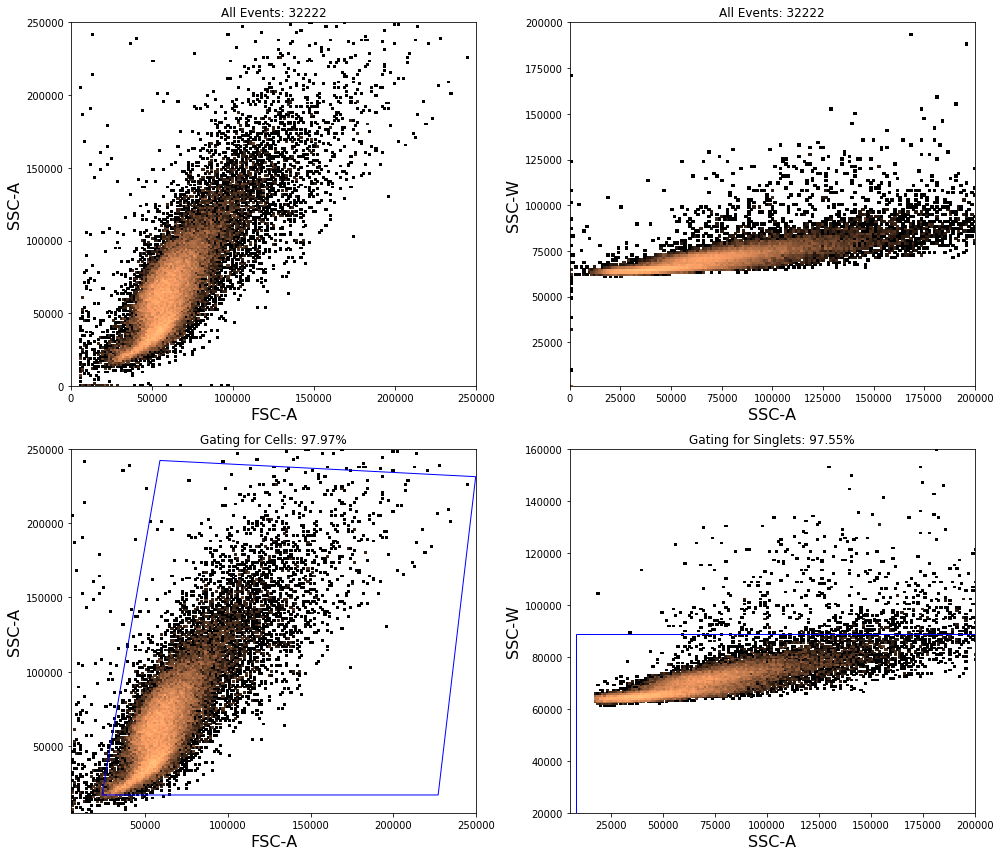

In [7]:
##This is to test the gating of the populations I have.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)
#print("The gated events as cells are: ", 
#(100*galE05973_Cells.get_data().shape[0]/galE05973.get_data().shape[0]))
#print("The gated events as singlets are: ", 
#(100*galE05973_Singlets.get_data().shape[0]/galE05973_Cells.get_data().shape[0]))

#I am going to be plotting these in the figures above, and in particular the Singlets 
#are gated on the Yeast Cell population.
figure(figsize=(14,12))
ax1 = subplot(221)
plateFCS['A1'].plot(['FSC-A','SSC-A'], kind='histogram');
title('All Events: {}'.format(plateFCS['A1'].get_data().shape[0]));
xlim((0,250000))
ylim((0,250000))
ax2 = subplot(222)
plateFCS['A1'].plot(['SSC-A','SSC-W'], kind='histogram');
title('All Events: {}'.format(plateFCS['A1'].get_data().shape[0]));
xlim((0,200000))
ylim((1000,200000))
ax3 = subplot(223)
plateFCS['A1'].plot(['FSC-A','SSC-A'], kind='histogram', gates=[cellsGate]);
title('Gating for Cells: {0:.2f}%'.format
      (100*plateFCS_Cells['A1'].get_data().shape[0]/plateFCS['A1'].get_data().shape[0]));
xlim((5000,250000))
ylim((5000,250000))
ax2 = subplot(224)
plateFCS_Cells['A1'].plot(['SSC-A','SSC-W'], kind='histogram', gates=[singletsGate]);
title('Gating for Singlets: {0:.2f}%'.format
      (100*plateFCS_Singlets['A1'].get_data().shape[0]/plateFCS_Cells['A1'].get_data().shape[0]));
xlim((5000,200000))
ylim((20000,160000))
plt.tight_layout()

#savefig('test.png')

In [8]:
#This is to plot the medians of all the samples in the plate.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
plotData.to_csv(root_dir+data_dir+'/rawMediansTable.csv', sep='\t', encoding='utf-8')
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
print(plotData)

                      Sample          GFP          RFP
0                       STE6  6838.479980   887.239990
1                       STE6  6902.719727   951.200012
2                       STE6  6840.239746  1009.419983
3                 YALIE05973  1045.439941  2601.859863
4                 YALIE05973  1022.559998  2707.639893
5                 YALIE05973  1039.280029  2605.139893
6                 TMH4-6/B11  4509.120117   587.940002
7                 TMH4-6/B11  4089.359863   466.579987
8                 TMH4-6/B11  4268.879883   555.960022
9                  TMH4-6/C9  3265.679932   441.980011
10                 TMH4-6/C9  3310.560059   509.220001
11                 TMH4-6/C9  3284.159912   414.100006
12               TMH10-12/D1  3813.040039  2200.060059
13               TMH10-12/D1  3956.479980  2678.939941
14               TMH10-12/D1  3868.479980  2505.100098
15              TMH10-12/D11  3204.959961  2282.879883
16              TMH10-12/D11  3357.199951  2424.739990
17        

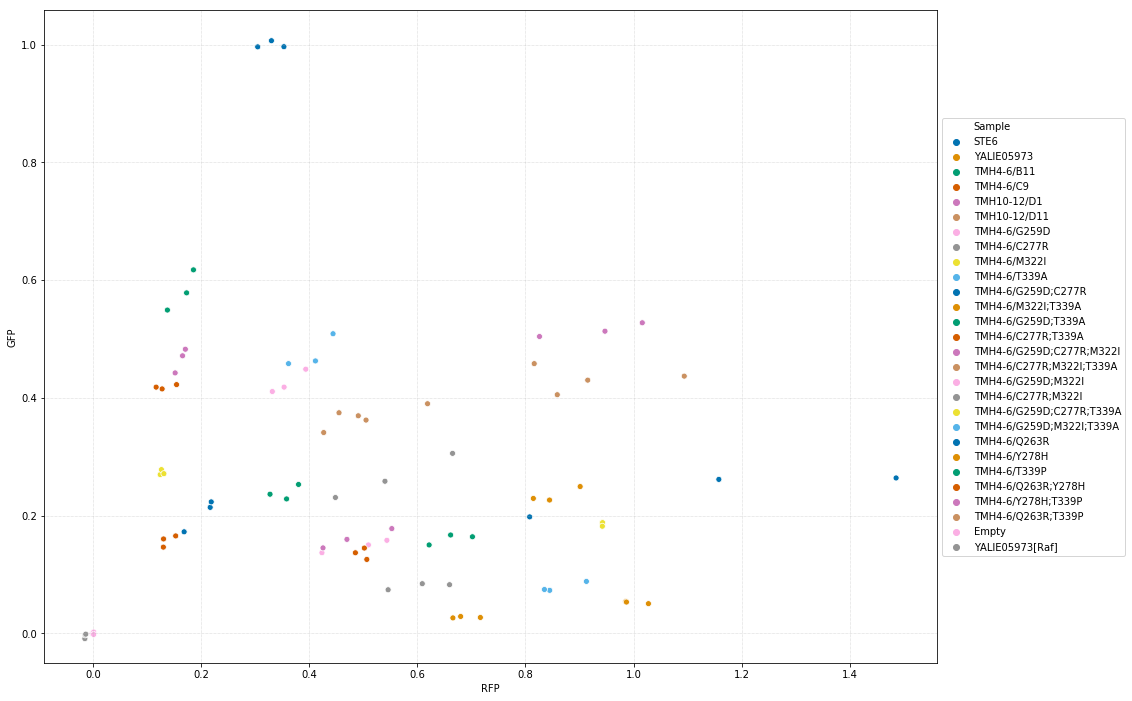

In [9]:
#This is to plot the medians of all the samples in the plate.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)
#plotData["RFP"] = plotData["RFP"]/CtrlRFP

fig1 = figure(figsize=(16,12))
ax1 = plt.subplot()
ax1 = sns.scatterplot(x="RFP", y="GFP", hue="Sample", data=plotData, palette="colorblind")
#ax1.set(xscale='log')
ax1.set_ylim(bottom=-0.05)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=True, linestyle='dotted', linewidth=0.5)

#savefig(root_dir+data_dir+'/Single-mutant-scatter.pdf', dpi=300, transparent=True)

##Apparently I shouldn't use the log plot once I switch to the normalization protocol I have here. Not totally sure why this
##is true...

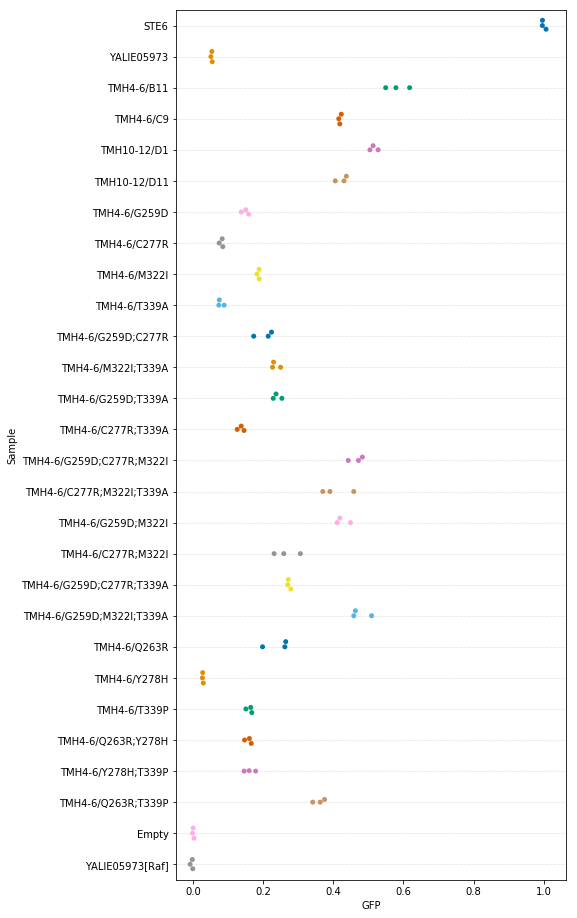

In [10]:
#This is to plot the GFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig1 = figure(figsize=(7,16))
ax = sns.swarmplot(x="GFP", y="Sample", data=plotData, palette="colorblind")
ax.set_xlim(left=-0.05)
plt.grid(b=True, axis='y', linestyle='dotted', linewidth=0.5)

#savefig(root_dir+data_dir+'/Single-mutant-swarm-GFP.pdf', dpi=300, transparent=True)

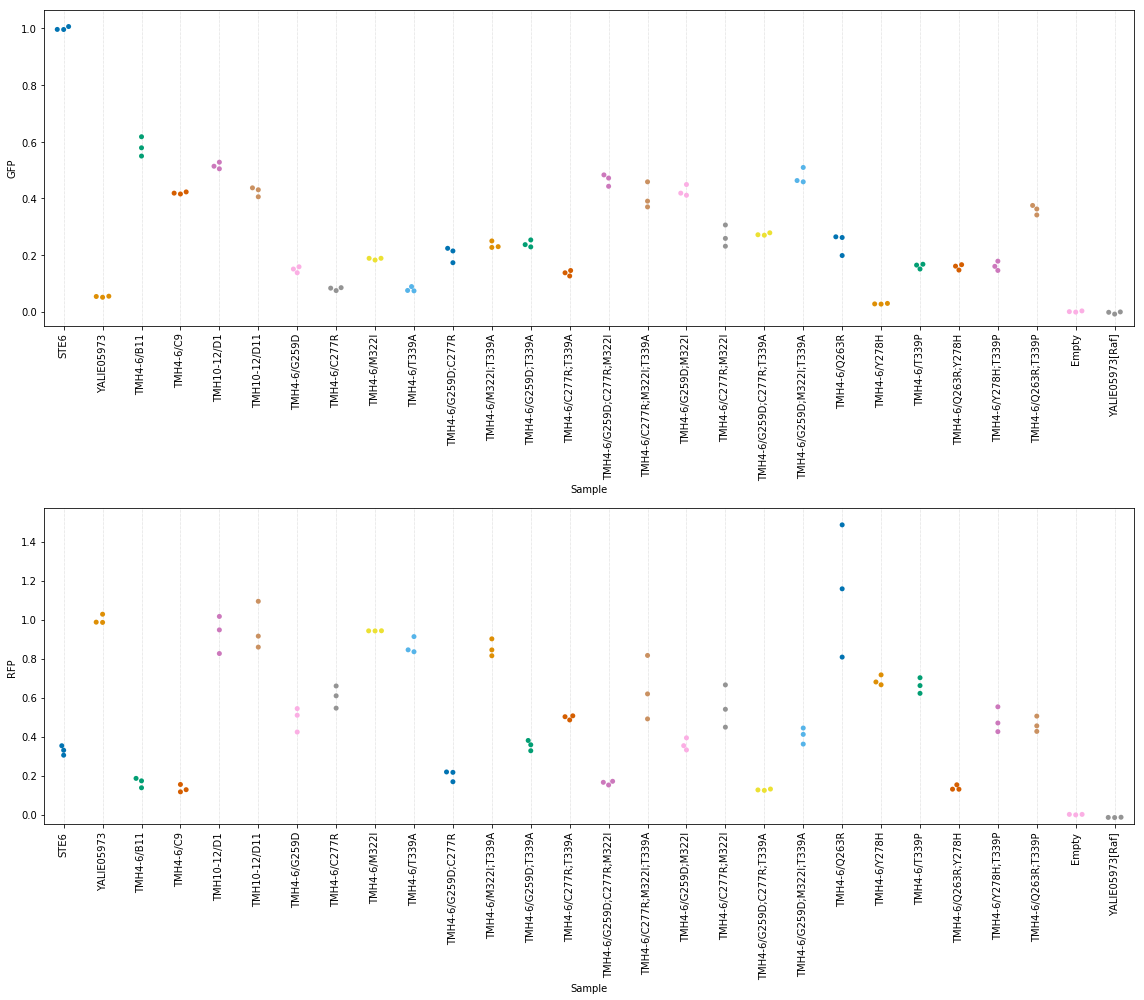

In [11]:
#This is to plot the GFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig1 = figure(figsize=(16,14))
ax1 = subplot(211)
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotData, palette="colorblind")
ax1.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=90)

ax2 = subplot(212)
ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotData, palette="colorblind")
ax2.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()

#savefig(root_dir+data_dir+'/Single-mutant-swarm-GFP.pdf', dpi=300, transparent=True)

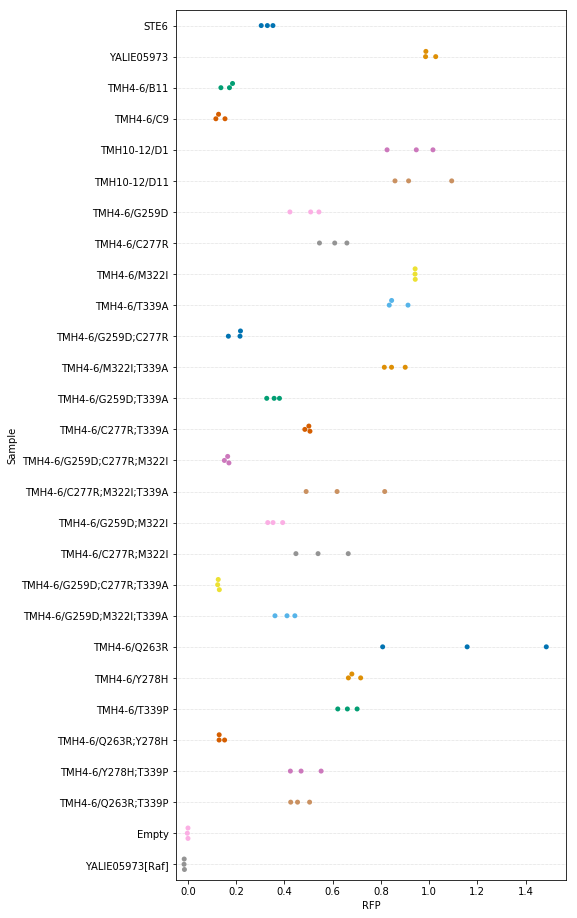

In [12]:
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig1 = figure(figsize=(7,16))
ax = sns.swarmplot(x="RFP", y="Sample", data=plotData, palette="colorblind")
ax.set_xlim(left=-0.05)
plt.grid(b=True, axis='y', linestyle='dotted', linewidth=0.5)

#savefig(root_dir+data_dir+'/SortedClones-swarm.pdf', dpi=300, transparent=True)

84


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

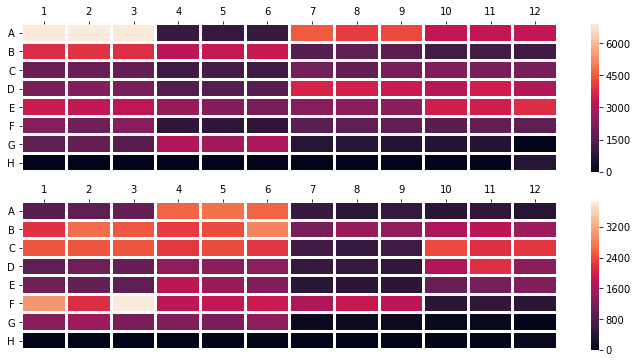

In [13]:
##I want to make heatmaps of the median values of the various clones that are run in plates.
##From Seaborn I need to provide the data as a 2D dataframe with the indices/columns providing the data for rows/columns.

##My plan to do this is to see if I can use an iterator to make the 2D array. I need to figure out what the best way to include
##the labels for the rows and columns.
#Starting with the 
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)
print(len(keyDict))

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(Medians)

heatMapGFP = [[0 for i in range(12)] for j in range(8)]
heatMapRFP = [[0 for i in range(12)] for j in range(8)]
#print(heatMapGFP)
for iterCount in range(len(keyDict)):
    heatMapGFP[(iterCount-1)//12][(iterCount-1)%12] = Medians[iterCount-1][1]
    heatMapRFP[(iterCount-1)//12][(iterCount-1)%12] = Medians[iterCount-1][2]
#print(heatMapGFP)

fig1 = figure(figsize=(12,6))
ax1 = subplot(211)
ax1 = sns.heatmap(heatMapGFP, xticklabels=list(range(13))[1:], yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
                  linewidths=2)
ax1.xaxis.tick_top()
plt.yticks(rotation=0)
ax2 = subplot(212)
ax2= sns.heatmap(heatMapRFP, xticklabels=list(range(13))[1:], yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
                 linewidths=2)
ax2.xaxis.tick_top()
plt.yticks(rotation=0)

##See below for updated version of optimum plotting##
##############################################################################
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

fig_file = root_dir+data_dir+'/Figure1.csv'
print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    plotSamples = [rows[0] for rows in reader]
    
#print(plotSamples)
plotDataFig1 = plotData[plotData.Sample.isin(plotSamples)]
#print(plotDataFig1)

fig1 = figure(figsize=(12,8))
ax = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig1, palette="colorblind")
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)

#savefig('Single-mutant-swarm-GFP.pdf', dpi=300, transparent=True)
############################################################################

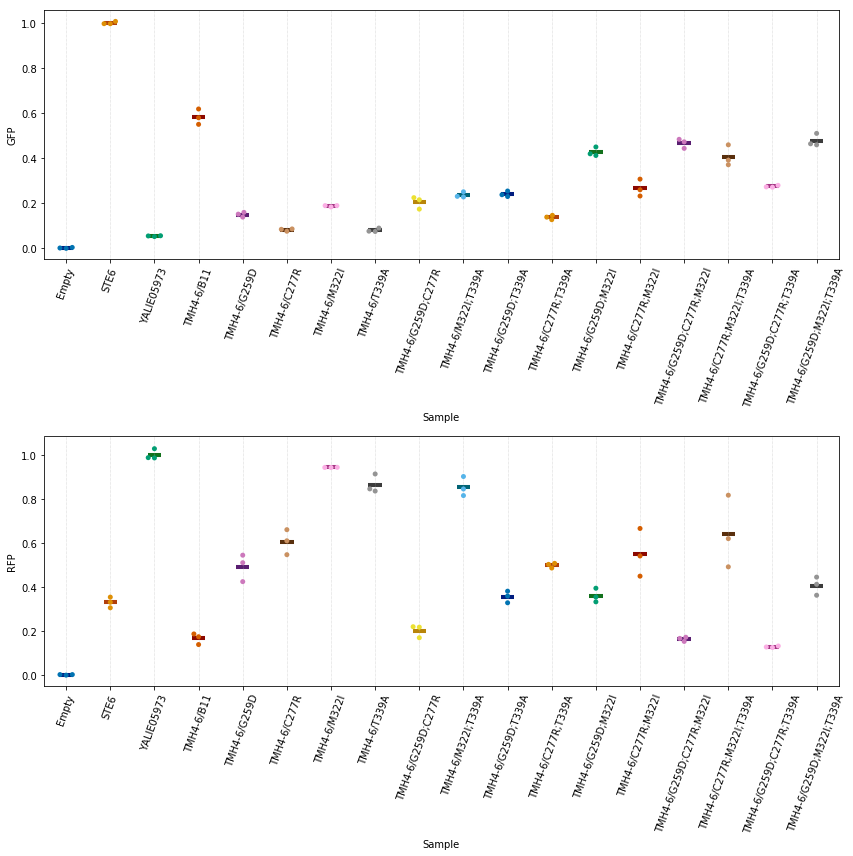

In [14]:
##Figure 1##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure1.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    plotSamples = [rows[0] for rows in reader]
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig1 = pd.DataFrame()
for label in plotSamples:
    plotDataFig1 = plotDataFig1.append(plotData.groupby(['Sample']).get_group(label))
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig1)

fig1 = figure(figsize=(12,12))
ax1 = subplot(211)
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig1, palette="colorblind")
ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig1, join=False, palette="dark",
              markers="_", scale=2, ci=None)
ax1.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)

ax2 = subplot(212)
ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig1, palette="colorblind")
ax2 = sns.pointplot(x="Sample", y="RFP", data=plotDataFig1, join=False, palette="dark",
              markers="_", scale=2, ci=None)
ax2.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)
plt.tight_layout()

#savefig(root_dir+data_dir+'/Single-mutant-Fig1.pdf', dpi=300, transparent=True)

[Text(0, 0, 'Empty'),
 Text(0, 0, 'STE6'),
 Text(0, 0, 'YALIE05973'),
 Text(0, 0, 'TMH4-6/B11'),
 Text(0, 0, 'TMH4-6/G259D'),
 Text(0, 0, 'TMH4-6/C277R'),
 Text(0, 0, 'TMH4-6/M322I'),
 Text(0, 0, 'TMH4-6/T339A'),
 Text(0, 0, 'TMH4-6/G259D;C277R'),
 Text(0, 0, 'TMH4-6/M322I;T339A'),
 Text(0, 0, 'TMH4-6/G259D;T339A'),
 Text(0, 0, 'TMH4-6/C277R;T339A'),
 Text(0, 0, 'TMH4-6/G259D;M322I'),
 Text(0, 0, 'TMH4-6/C277R;M322I'),
 Text(0, 0, 'TMH4-6/G259D;C277R;M322I'),
 Text(0, 0, 'TMH4-6/C277R;M322I;T339A'),
 Text(0, 0, 'TMH4-6/G259D;C277R;T339A'),
 Text(0, 0, 'TMH4-6/G259D;M322I;T339A')]

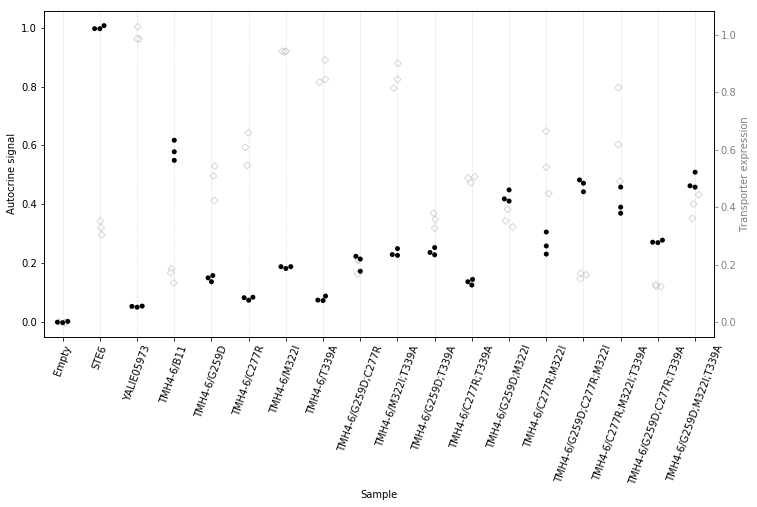

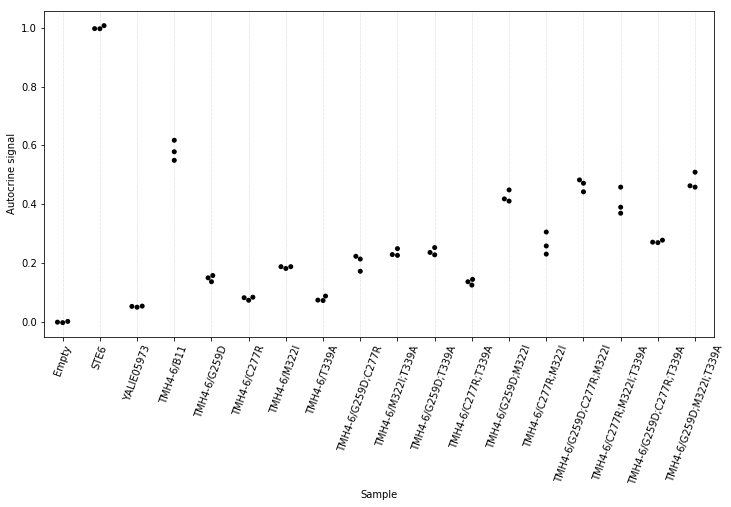

In [13]:
##Figure 1 combined into single panel##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels);
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure1.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile);
    plotSamples = [rows[0] for rows in reader];
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig1 = pd.DataFrame()
for label in plotSamples:
    plotDataFig1 = plotDataFig1.append(plotData.groupby(['Sample']).get_group(label));
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig1)

##Combining the GFP/RFP signals in a single plot with two axes.
fig2 = figure(figsize=(12,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig1, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig1, join=False, color="black",
#              markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax2 = ax1.twinx()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax2 = sns.stripplot(x="Sample", y="RFP", data=plotDataFig1, color="white", ax=ax2, marker="D", edgecolor="gray", linewidth=0.75, jitter=True, alpha=0.5)
#ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig1, color="grey", ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Transporter expression', color="grey")
ax2.tick_params('y', color="grey", labelcolor="grey")
ax2.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Multi-mutant-B11-combine-Fig1-1_191124.pdf', dpi=300, transparent=True)

##Combining the GFP signals in a single plot with two axes.
fig3 = figure(figsize=(12,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig1, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig1, join=False, color="black", 
#                    markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Multi-mutant-B11-GFP-Fig1.pdf', dpi=300, transparent=True)

##Combining the GFP/RFP signals in a single plot.
meltedPlotDataFig1 = pd.melt(plotDataFig1, "Sample", var_name="measurement");
fig1 = figure(figsize=(16,6))
ax1 = sns.swarmplot(x="Sample", y="value", hue="measurement", data=meltedPlotDataFig1, palette="colorblind", dodge=True)
ax1 = sns.pointplot(x="Sample", y="value", hue="measurement", data=meltedPlotDataFig1, join=False, palette="dark",
              markers="_", scale=2, ci=None, dodge=0.4)
ax1.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Single-mutant-combine-Fig1.pdf', dpi=300, transparent=True)

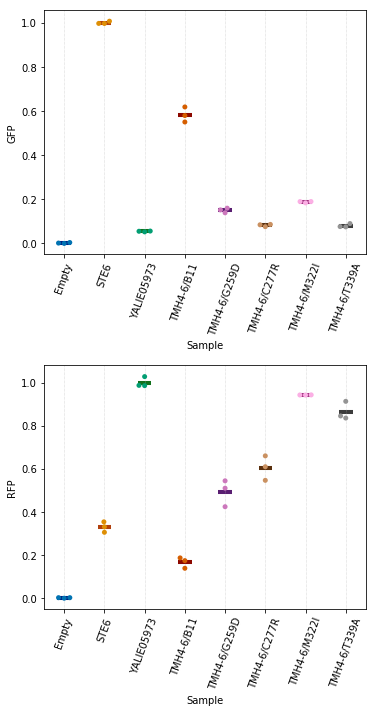

In [18]:
##Figure 2##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

plotSamples = []
fig_file = root_dir+data_dir+'/Figure2.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    plotSamples = [rows[0] for rows in reader]
#print(plotSamples)
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig2 = pd.DataFrame()
for label in plotSamples:
    #print(label)
    plotDataFig2 = plotDataFig2.append(plotData.groupby(['Sample']).get_group(label))
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig2)

fig2 = figure(figsize=(5.33,10))
ax1 = subplot(211)
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig2, palette="colorblind")
ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig2, join=False, palette="dark",
              markers="_", scale=2, ci=None)
ax1.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)

ax2 = subplot(212)
ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig2, palette="colorblind")
ax1 = sns.pointplot(x="Sample", y="RFP", data=plotDataFig2, join=False, palette="dark",
              markers="_", scale=2, ci=None)
ax2.set_ylim(bottom=-0.05)
plt.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
plt.xticks(rotation=70)
plt.tight_layout()

#savefig(root_dir+data_dir+'/Single-mutant-Fig2.pdf', dpi=300, transparent=True)

[Text(0, 0, 'Empty'),
 Text(0, 0, 'STE6'),
 Text(0, 0, 'YALIE05973'),
 Text(0, 0, 'TMH4-6/B11'),
 Text(0, 0, 'TMH4-6/G259D'),
 Text(0, 0, 'TMH4-6/C277R'),
 Text(0, 0, 'TMH4-6/M322I'),
 Text(0, 0, 'TMH4-6/T339A')]

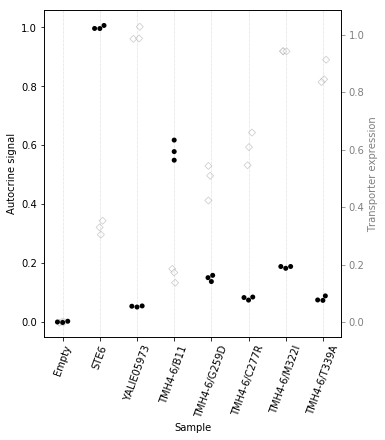

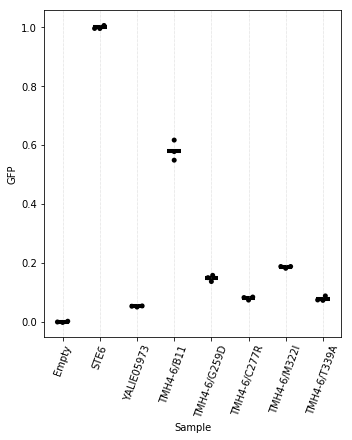

In [14]:
##Figure 2 combined into single panel##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels)
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure2.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    plotSamples = [rows[0] for rows in reader]
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig2 = pd.DataFrame()
for label in plotSamples:
    plotDataFig2 = plotDataFig2.append(plotData.groupby(['Sample']).get_group(label))
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig2)

##Combining the GFP/RFP signals in a single plot with two axes.
fig2 = figure(figsize=(5.33,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig2, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig2, join=False, color="black",
#              markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax2= ax1.twinx()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax2 = sns.stripplot(x="Sample", y="RFP", data=plotDataFig2, color="white", ax=ax2, marker="D", edgecolor="gray", linewidth=0.75, jitter=True, alpha=0.5)
#ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig2, color="grey", ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Transporter expression', color="grey")
ax2.tick_params('y', color="grey", labelcolor="grey")
ax2.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Single-mutant-B11-combine-Fig2.pdf', dpi=300, transparent=True)

##Combining the GFP signals in a single plot with two axes.
fig3 = figure(figsize=(5.33,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig2, color="black")
ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig2, join=False, color="black", 
                    markers="_", scale=2, ci=None)
ax1.set_ylabel('GFP', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Single-mutant-B11-GFP-Fig2.pdf', dpi=300, transparent=True)

[Text(0, 0, 'Empty'),
 Text(0, 0, 'YALIE05973[Raf]'),
 Text(0, 0, 'STE6'),
 Text(0, 0, 'YALIE05973'),
 Text(0, 0, 'TMH4-6/B11'),
 Text(0, 0, 'TMH4-6/C9'),
 Text(0, 0, 'TMH10-12/D1'),
 Text(0, 0, 'TMH10-12/D11')]

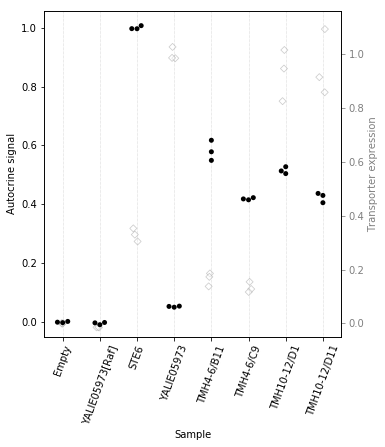

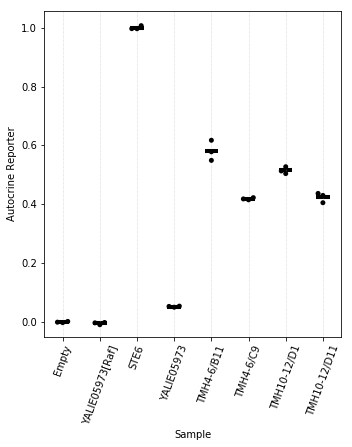

In [15]:
##Figure 3 combined into single panel##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels);
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure3.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile);
    plotSamples = [rows[0] for rows in reader];
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig3 = pd.DataFrame()
for label in plotSamples:
    plotDataFig3 = plotDataFig3.append(plotData.groupby(['Sample']).get_group(label));
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig1)

##Combining the GFP/RFP signals in a single plot with two axes.
fig2 = figure(figsize=(5.33,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig3, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig3, join=False, color="black",
#              markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax2 = ax1.twinx()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax2 = sns.stripplot(x="Sample", y="RFP", data=plotDataFig3, color="white", ax=ax2, marker="D", edgecolor="gray", linewidth=0.75, jitter=True, alpha=0.5)
#ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig3, color="grey", ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Transporter expression', color="grey")
ax2.tick_params('y', color="grey", labelcolor="grey")
ax2.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Selected-clones-combine-Fig3_191124.pdf', dpi=300, transparent=True)

##Combining the GFP signals in a single plot with two axes.
fig3 = figure(figsize=(5.33,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig3, color="black")
ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig3, join=False, color="black", 
                    markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine Reporter', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Selected-clones-GFP-Fig3.pdf', dpi=300, transparent=True)

[Text(0, 0, 'Empty'),
 Text(0, 0, 'STE6'),
 Text(0, 0, 'YALIE05973'),
 Text(0, 0, 'TMH4-6/B11'),
 Text(0, 0, 'TMH4-6/G259D'),
 Text(0, 0, 'TMH4-6/C277R'),
 Text(0, 0, 'TMH4-6/M322I'),
 Text(0, 0, 'TMH4-6/T339A'),
 Text(0, 0, 'TMH4-6/C9'),
 Text(0, 0, 'TMH4-6/Q263R'),
 Text(0, 0, 'TMH4-6/Y278H'),
 Text(0, 0, 'TMH4-6/T339P')]

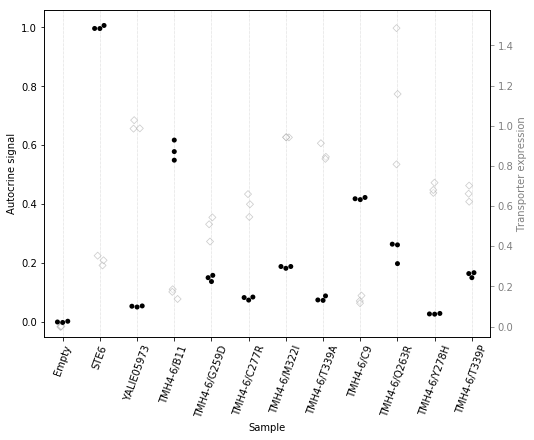

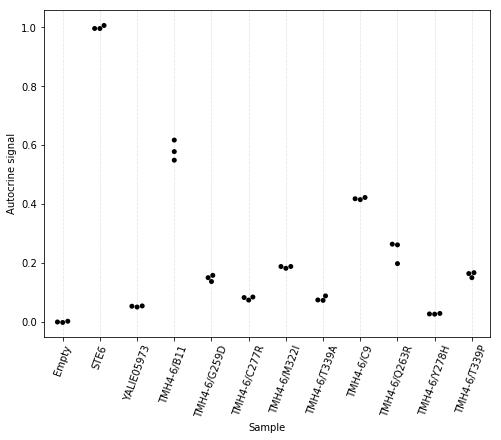

In [16]:
##Figure 4 combined into single panel##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels);
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure4.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile);
    plotSamples = [rows[0] for rows in reader];
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig4 = pd.DataFrame()
for label in plotSamples:
    plotDataFig4 = plotDataFig4.append(plotData.groupby(['Sample']).get_group(label));
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig1)

##Combining the GFP/RFP signals in a single plot with two axes.
fig2 = figure(figsize=(8,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig4, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig4, join=False, color="black",
#              markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax2 = ax1.twinx()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax2 = sns.stripplot(x="Sample", y="RFP", data=plotDataFig4, color="white", ax=ax2, marker="D", edgecolor="gray", linewidth=0.75, jitter=True, alpha=0.5)
#ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig4, color="grey", ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Transporter expression', color="grey")
ax2.tick_params('y', color="grey", labelcolor="grey")
ax2.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Single-mutant-B11-C9-combine-Fig4_191124.pdf', dpi=300, transparent=True)

##Combining the GFP signals in a single plot with two axes.
fig3 = figure(figsize=(8,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig4, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig4, join=False, color="black", 
#                    markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Single-mutant-B11-C9-GFP-Fig4.pdf', dpi=300, transparent=True)

[Text(0, 0, 'Empty'),
 Text(0, 0, 'STE6'),
 Text(0, 0, 'YALIE05973'),
 Text(0, 0, 'TMH4-6/C9'),
 Text(0, 0, 'TMH4-6/Q263R'),
 Text(0, 0, 'TMH4-6/Y278H'),
 Text(0, 0, 'TMH4-6/T339P'),
 Text(0, 0, 'TMH4-6/Q263R;Y278H'),
 Text(0, 0, 'TMH4-6/Y278H;T339P'),
 Text(0, 0, 'TMH4-6/Q263R;T339P')]

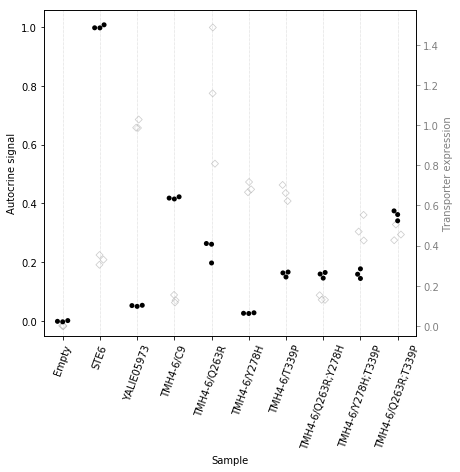

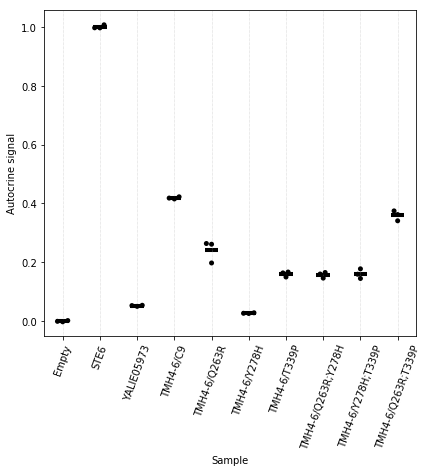

In [17]:
##Figure 5 combined into single panel##
#This is to plot the RFP medians of all the samples in the plate, with triplicates plotted together.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels);
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

fig_file = root_dir+data_dir+'/Figure5.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile);
    plotSamples = [rows[0] for rows in reader];
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotDataFig5 = pd.DataFrame()
for label in plotSamples:
    plotDataFig5 = plotDataFig5.append(plotData.groupby(['Sample']).get_group(label));
#print(plotData.groupby(['Sample']).get_group(plotSamples[0]))
#print(plotDataFig1)

##Combining the GFP/RFP signals in a single plot with two axes.
fig2 = figure(figsize=(6.67,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig5, color="black")
#ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig5, join=False, color="black",
#              markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax2 = ax1.twinx()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax2 = sns.stripplot(x="Sample", y="RFP", data=plotDataFig5, color="white", ax=ax2, marker="D", edgecolor="gray", linewidth=0.75, jitter=True, alpha=0.5)
#ax2 = sns.swarmplot(x="Sample", y="RFP", data=plotDataFig5, color="grey", ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Transporter expression', color="grey")
ax2.tick_params('y', color="grey", labelcolor="grey")
ax2.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Multi-mutant-C9-combine-Fig5_191124.pdf', dpi=300, transparent=True)

##Combining the GFP signals in a single plot with two axes.
fig3 = figure(figsize=(6.67,6))
ax1 = sns.swarmplot(x="Sample", y="GFP", data=plotDataFig5, color="black")
ax1 = sns.pointplot(x="Sample", y="GFP", data=plotDataFig5, join=False, color="black", 
                    markers="_", scale=2, ci=None)
ax1.set_ylabel('Autocrine signal', color="black")
ax1.tick_params('y', color="black", labelcolor="black")
ax1.set_ylim(bottom=-0.05)

ax1.grid(b=True, axis='x', linestyle='dotted', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)
#plt.xticks(rotation=70)
#savefig(root_dir+data_dir+'/Multi-mutant-C9-GFP-Fig5.pdf', dpi=300, transparent=True)

In [12]:
##Extracting the medians for the populations after normalizing to use for PyMol##
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)

Medians = []
for key in keyDict:
    Medians.append([keyDict[key], plateFCS_Singlets[key].data['FITC-A'].median(), 
                   plateFCS_Singlets[key].data['PE-Texas Red-A'].median()])
Labels = ['Sample', 'GFP', 'RFP']
#print(Medians)
plotData = pd.DataFrame.from_records(Medians, columns=Labels);
#print(plotData.keys())
#plotData.sort_values(by='Sample', axis=1)
#print(plotData)

##Normalization of the FACS signals with positive and negative control samples.
CtrlGFP = (plotData.groupby(['Sample']).get_group("STE6"))["GFP"].mean()
MinCtrlGFP = (plotData.groupby(['Sample']).get_group("Empty"))["GFP"].mean()
plotData["GFP"] = (plotData["GFP"]-MinCtrlGFP)/(CtrlGFP-MinCtrlGFP)
CtrlRFP = (plotData.groupby(['Sample']).get_group("YALIE05973"))["RFP"].mean()
MinCtrlRFP = (plotData.groupby(['Sample']).get_group("Empty"))["RFP"].mean()
plotData["RFP"] = (plotData["RFP"]-MinCtrlRFP)/(CtrlRFP-MinCtrlRFP)

#table_file = root_dir+data_dir+'/Table1.csv'
#print(fig_file)
#with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
#    reader = csv.reader(infile);
#    saveSamples = [rows[0] for rows in reader];

#print(plotSamples)
#plotDataFig5 = pd.DataFrame()
#for label in plotSamples:
#    plotDataFig5 = plotDataFig5.append(plotData.groupby(['Sample']).get_group(label));

plotData.to_csv(root_dir+data_dir+'/mediansTable.csv', sep='\t', encoding='utf-8')

In [9]:
plateFCS_SingletsCopy['A1'].head()

AttributeError: 'FCMeasurement' object has no attribute 'head'

In [8]:
##Trying to add (FITC-A/PE-Texas Red-A) ratios to the pandas dataframe. Remember you need to run the cell with the functions at the top.
plateFCS_Cells = plateFCS.gate(cellsGate)
plateFCS_Singlets = plateFCS_Cells.gate(singletsGate)
plateFCS_SingletsCopy = plateFCS_Singlets.copy()

for well in plateFCS_Singlets:
    plateFCS_SingletsCopy['GFPdiff'] = plateFCS_SingletsCopy.apply(lambda row: GFPRFPratio(row), axis = 1)

plateFCS_SingletsCopy['A1'].head()

TypeError: apply() got an unexpected keyword argument 'axis'